In [65]:
import pandas as pd

# Load the dataset
file_path = "flood_df_full_merged1.csv"
df = pd.read_csv(file_path)
df = df.drop_duplicates()

In [66]:
# Show all column names after modifications
# df.columns.tolist()
# One-hot encode the 'season' column
df = pd.get_dummies(df, columns=['season','month'], drop_first=True)

# Drop specified columns

drop_cols = ['state.x', 'county.x', 'date', 
             'total_injuries', 'total_deaths', 'total_property_damage', 
             'n_episodes', 'n_events', 'other',
             'area_km2', 'exposed_population',
            ]
df = df.drop(columns=drop_cols)

# Confirm resulting columns
#df.columns.tolist()


In [67]:
len(df)


2595

In [68]:
df.columns.tolist()

['label',
 'days_since_last_damaging_flood',
 'days_since_prev_flood',
 'min.2',
 'max.2',
 'mean.2',
 'min.1',
 'max.1',
 'mean.1',
 'min',
 'max',
 'mean',
 'builtup',
 'forest',
 'agriculture',
 'impervious',
 'total_pop.x',
 'median_income',
 'pop_density',
 'total_population',
 'pct_exposed',
 'pct_age_65plus',
 'pct_less_hs',
 'pct_below_poverty',
 'pct_hispanic',
 'pct_nh_black',
 'road_density_km_per_km2',
 'season_Spring',
 'season_Summer',
 'season_Winter',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12']

In [69]:
df['days_since_last_damaging_flood'].isna().sum()



367

In [70]:
df['days_since_prev_flood'].isna().sum() # 1995.12.21

161

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       329
           1       0.78      0.61      0.68       190

    accuracy                           0.79       519
   macro avg       0.79      0.75      0.76       519
weighted avg       0.79      0.79      0.79       519

ROC-AUC: 0.8548
AUC-PR: 0.8035


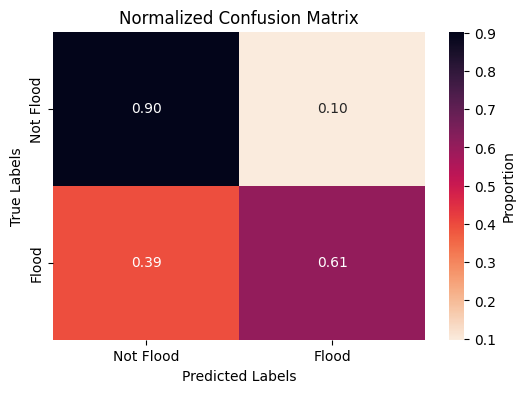

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    auc,
    confusion_matrix
)
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Separate features and label
X = df.drop(columns=['label'])
y = df['label']

# Fill missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=500, random_state=1, n_jobs=-1)
random_forest_model.fit(X_train, y_train)

# Predict and compute probabilities
y_pred = random_forest_model.predict(X_test)
y_prob = random_forest_model.predict_proba(X_test)[:, 1]

# Output classification report
print(classification_report(y_test, y_pred))

# Calculate evaluation metrics
roc_auc = roc_auc_score(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_pr = auc(recall, precision)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"AUC-PR: {auc_pr:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
c_matrix = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(c_matrix, annot=True, cmap='rocket_r', fmt='.2f',
            xticklabels=['Not Flood', 'Flood'],
            yticklabels=['Not Flood', 'Flood'],
            cbar_kws={'label': 'Proportion'})
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

                           Feature  Importance
0   days_since_last_damaging_flood    0.111880
12                          forest    0.062828
1            days_since_prev_flood    0.059665
16                   median_income    0.044455
24                    pct_nh_black    0.041837
9                              max    0.040779
8                              min    0.039063
10                            mean    0.038684
7                           mean.1    0.038413
6                            max.1    0.037476
5                            min.1    0.037454
14                      impervious    0.035645
13                     agriculture    0.032778
11                         builtup    0.030100
23                    pct_hispanic    0.027177
4                           mean.2    0.025590
20                  pct_age_65plus    0.024916
3                            max.2    0.024782
15                     total_pop.x    0.024065
18                total_population    0.023761
17           

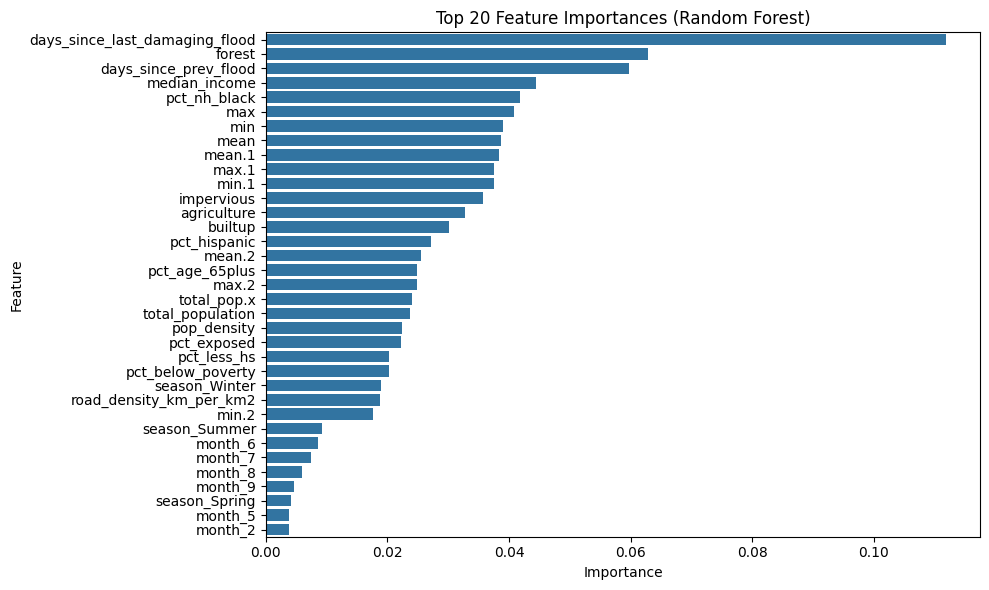

In [72]:
# Get feature importance scores
importances = random_forest_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for sorting and visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Optional: Plot the top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(35))
plt.title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()
